In [47]:
#Importing Packages 
import torch
import torchvision
import torchvision.transforms as transforms

In [48]:
batch_size = 32

#Data Augmentation
Image_Aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=25),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

#Simple Data Augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=Image_Aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


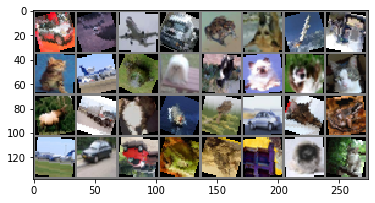

car   deer  plane truck frog  dog   plane truck cat   plane frog  dog   cat   cat   dog   cat   deer  truck cat   ship  bird  car   cat   frog  plane car   car   frog  frog  truck dog   cat  


In [49]:
import matplotlib.pyplot as plt
import numpy as np

#seeing images being processed by CNN

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [50]:
#CNN with Batch Norm, Maxpool, and Dropout

import torch.nn as nn
import torch.nn.functional as F


class NetBasic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm2d(32) #Implimenting Batch Normalization 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=2)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1600,512)
        self.drop = nn.Dropout(p=0.5) #Implimenting Dropout
        self.batchlin = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.batch1(F.relu(self.conv1(x)))#adding batch norm
        x = self.pool(x)
        x = self.batch2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.batch2(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)#adding dropout
        x = self.batchlin(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.batchlin(x)
        x = self.fc3(x)
        return x


net = NetBasic()

In [51]:
#Useing Adam Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [57]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [54]:
net = NetBasic()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [55]:
#Testing your CNN
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [56]:
# Acccuracy of Different Classes 

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.2 %
Accuracy for class: car   is 65.5 %
Accuracy for class: bird  is 36.9 %
Accuracy for class: cat   is 26.1 %
Accuracy for class: deer  is 39.2 %
Accuracy for class: dog   is 44.3 %
Accuracy for class: frog  is 66.3 %
Accuracy for class: horse is 63.0 %
Accuracy for class: ship  is 67.1 %
Accuracy for class: truck is 58.2 %
